In [1]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, classification_report,
    roc_auc_score, precision_score, recall_score, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from utils.data_utils import load_data, process_data_for_rf, process_data_for_lr, process_data_for_xgboost
from utils.embeddings import EmbeddingExtractor
from utils.evaluation import evaluate_model, plot_confusion_matrix, plot_roc_curve

# Set seaborn style for better visualizations
sns.set_theme(style="whitegrid")
sns.set_palette("Blues")
plt.rcParams['figure.figsize'] = [10, 6]

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Hospital Admission Prediction - Ensemble Model Evaluation

This notebook demonstrates the performance of our ensemble model and its component models on a validation dataset. The ensemble combines the strengths of three different machine learning approaches:

1. **XGBoost** - Utilizing embeddings from the chief complaint text
2. **Random Forest** - Using complexity scores and structured features
3. **Logistic Regression** - With carefully selected features and parameter tuning

The ensemble model leverages the predictions from these three models to make more robust and accurate predictions about hospital admissions.

## Related Notebooks
- [Logistic Regression Experiments](logreg_experiments.ipynb) - Detailed experiments with logistic regression
- [Failure Analysis](failure_analysis.ipynb) - Analysis of logistic regression failure cases
- [PCA Experiments](pca.ipynb) - PCA dimensionality reduction for XGBoost

## Project Overview

This project aims to predict whether a patient visiting the emergency department will be admitted to the hospital or sent home, based on their initial presentation data. Accurate prediction can help with resource allocation and patient flow management.

In [2]:
# Cell 3 - Load validation data
print("Loading validation data...")
validation_df = pd.read_csv('validation.csv')
print(f"Loaded validation dataset with {validation_df.shape[0]} rows and {validation_df.shape[1]} columns")

# Display a sample of the data
validation_df.head()

Loading validation data...
Loaded validation dataset with 5000 rows and 32 columns


,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,...,sbp_category,temp_category,dbp_category,pain_category,acuity_category,age_category,day_shift,shock_index,sirs,disposition_enc
0,14226808,37743904,99.0,97.0,18.0,95.0,128.0,72.0,0.0,3.0,...,normal,normal,normal,no pain,acuity_3,adult,True,0.757812,1,1
1,14916430,38358328,98.0,131.0,18.0,92.0,80.0,46.0,4.4,1.0,...,low,normal,low,moderate,acuity_1,adult,True,1.637500,1,0
2,12698808,30248392,98.2,62.0,19.0,99.0,106.0,62.0,0.0,2.0,...,normal,normal,normal,no pain,acuity_2,middle_aged,True,0.584906,0,0
3,16995942,31527454,96.7,35.0,28.0,93.0,136.0,31.0,4.4,1.0,...,normal,hypothermic,low,moderate,acuity_1,senior,True,0.257353,1,0
4,14241385,38368612,98.7,112.0,16.0,99.0,112.0,75.0,10.0,3.0,...,normal,normal,normal,severe,acuity_3,adult,False,1.000000,1,1


## Model Loading

We'll load all our trained models, including:
1. The base models (XGBoost, Random Forest, Logistic Regression)
2. The tuned ensemble model

Each model has its own preprocessing requirements, which we'll handle separately.

In [3]:
# Cell 5 - Load models
def load_base_models():
    """Load all base models and their associated components"""
    print("Loading base models...")
    
    models = {
        'xgb': {
            'model': joblib.load("models/xgboost_model.pkl"),
            'scaler': joblib.load('models/xgb_scaler.pkl'),
            'encoder': joblib.load('models/xgb_label_encoder.pkl'),
            'pca': joblib.load('models/xgb_pca.pkl')
        },
        'rf': {
            'model': joblib.load("models/random_forest_model.pkl"),
            'scaler': joblib.load('models/rf_scaler.pkl'),
            'encoder': joblib.load('models/rf_encoder.pkl')
        },
        'lr': {
            'model': joblib.load("models/logistic_regression_model.pkl"),
            'scaler': joblib.load('models/lr_scaler.pkl'),
            'encoder': joblib.load('models/lr_encoder.pkl'),
            'preprocessor': joblib.load('models/lr_preprocessor.pkl')
        }
    }
    
    # Add process functions
    models['xgb']['process_func'] = process_data_for_xgboost
    models['rf']['process_func'] = process_data_for_rf
    models['lr']['process_func'] = process_data_for_lr
    
    return models

# Load ensemble model
def load_ensemble_model():
    """Load the tuned ensemble model"""
    print("Loading ensemble model...")
    
    ensemble_model = joblib.load("ensemble/ensemble_model.pkl")
    
    return ensemble_model

# Load all models
base_models = load_base_models()
ensemble_model = load_ensemble_model()

print("All models loaded successfully!")

Loading base models...
Loading ensemble model...
All models loaded successfully!


## Data Processing

Each model requires specific preprocessing steps:

1. **XGBoost** - Requires text embeddings from the chief complaint, followed by PCA
2. **Random Forest** - Uses complexity scores and structured features
3. **Logistic Regression** - Uses a mix of numerical and categorical features

We'll process the validation data for each model separately.

In [4]:
# Cell 7 - Process data for all models
def process_data(df, models):
    """Process data for all models"""
    print("Processing data for all models...")
    
    df_subset = df[['disposition', 'chiefcomplaint']]
    
    # Process data for XGBoost
    embedder = EmbeddingExtractor()
    embeddings = embedder.get_or_create_embeddings(df_subset, column="chiefcomplaint")
    pca_obj = models['xgb']['pca']
    xgb_data = process_data_for_xgboost(embeddings, df['disposition'], pca_obj)
    
    # Process data for Random Forest
    rf_data = process_data_for_rf(df_subset)
    
    # Process data for Logistic Regression
    preprocessor = models['lr']['preprocessor']
    lr_data = process_data_for_lr(df, preprocessor=preprocessor, mode='inference')
    
    # Organize processed data
    data = {
        'xgb_X': xgb_data['X'],
        'xgb_y': xgb_data['y'],
        'rf_X': rf_data['X'],
        'rf_y': rf_data['y'],
        'lr_X': lr_data['X'],
        'lr_y': lr_data['y']
    }
    
    return data

# Process validation data
processed_data = process_data(validation_df, base_models)

print("Data processing complete!")

Processing data for all models...
Loading cached embeddings from embeddings\embeddings_7c423fb0e74c272948439dc5a2721bfc.joblib...
Loaded existing embeddings, shape: (5000, 1024)
Loading cached complexity features...
Data processing complete!


## Model Predictions

Now we'll use each model to make predictions on the validation data. For the ensemble model, we'll use the predictions from the base models as input features.

## Feature Interactions

The ensemble model uses not only the individual model probabilities but also:
1. The binary predictions (0/1) from each model
2. Feature interactions created by multiplying probabilities from different models:
   - Random Forest × Logistic Regression
   - Random Forest × XGBoost
   - Logistic Regression × XGBoost

These interaction features help the ensemble model capture relationships between different models' predictions, potentially improving overall performance when models have complementary strengths.

In [6]:
# Cell 9 - Get predictions from all models
def get_all_predictions(models, data):
    """Get predictions from all models"""
    print("Getting predictions from all models...")
    
    results = {}
    
    # XGBoost predictions
    results['xgb_predictions'] = models['xgb']['model'].predict(data['xgb_X'])
    results['xgb_probabilities'] = models['xgb']['model'].predict_proba(data['xgb_X'])[:, 1]
    
    # Random Forest predictions
    results['rf_predictions'] = models['rf']['model'].predict(data['rf_X'])
    results['rf_probabilities'] = models['rf']['model'].predict_proba(data['rf_X'])[:, 1]
    
    # Logistic Regression predictions
    results['lr_predictions'] = models['lr']['model'].predict(data['lr_X'])
    results['lr_probabilities'] = models['lr']['model'].predict_proba(data['lr_X'])[:, 1]
    
    return results

# Get predictions from base models
predictions = get_all_predictions(base_models, processed_data)

# Create meta-features for ensemble model
meta_features = np.column_stack([
    predictions['rf_probabilities'],
    predictions['lr_probabilities'],
    predictions['xgb_probabilities'],
    predictions['rf_predictions'],
    predictions['lr_predictions'],
    predictions['xgb_predictions'],
    predictions['rf_probabilities'] * predictions['lr_probabilities'],
    predictions['rf_probabilities'] * predictions['xgb_probabilities'],
    predictions['lr_probabilities'] * predictions['xgb_probabilities']
])

# Get ensemble predictions
ensemble_predictions = ensemble_model.predict(meta_features)
ensemble_probabilities = ensemble_model.predict_proba(meta_features)[:, 1]

print("All predictions complete!")

Getting predictions from all models...
All predictions complete!


## Model Evaluation

We'll evaluate each model's performance on the validation data using several metrics:
- Accuracy
- F1 Score
- Precision
- Recall
- ROC-AUC

We'll also visualize the results using confusion matrices and ROC curves.

In [7]:
# Cell 11 - Evaluate all models
def evaluate_all_models(base_models, predictions, data, ensemble_preds, ensemble_probs):
    """Evaluate all models and create visualizations"""
    print("Evaluating all models...")
    
    metrics = {}
    markdown_reports = {}
    
    # Evaluate XGBoost
    xgb_metrics, xgb_markdown = evaluate_model(
        data['xgb_y'], 
        predictions['xgb_predictions'],
        y_prob=predictions['xgb_probabilities'],
        model_name="XGBoost",
        label_encoder=base_models['xgb']['encoder']
    )
    metrics['xgb'] = xgb_metrics
    markdown_reports['xgb'] = xgb_markdown
    
    # Evaluate Random Forest
    rf_metrics, rf_markdown = evaluate_model(
        data['rf_y'], 
        predictions['rf_predictions'],
        y_prob=predictions['rf_probabilities'],
        model_name="Random Forest",
        label_encoder=base_models['rf']['encoder']
    )
    metrics['rf'] = rf_metrics
    markdown_reports['rf'] = rf_markdown
    
    # Evaluate Logistic Regression
    lr_metrics, lr_markdown = evaluate_model(
        data['lr_y'], 
        predictions['lr_predictions'],
        y_prob=predictions['lr_probabilities'],
        model_name="Logistic Regression",
        label_encoder=base_models['lr']['encoder']
    )
    metrics['lr'] = lr_metrics
    markdown_reports['lr'] = lr_markdown
    
    # Evaluate Ensemble model
    ensemble_metrics, ensemble_markdown = evaluate_model(
        data['lr_y'],  # Use any of the y values, they should be the same
        ensemble_preds,
        y_prob=ensemble_probs,
        model_name="Ensemble Model",
        label_encoder=base_models['lr']['encoder']
    )
    metrics['ensemble'] = ensemble_metrics
    markdown_reports['ensemble'] = ensemble_markdown
    
    return metrics, markdown_reports

# Evaluate all models
metrics, markdown_reports = evaluate_all_models(
    base_models, 
    predictions, 
    processed_data, 
    ensemble_predictions, 
    ensemble_probabilities
)

# Display evaluation reports
for model_name, report in markdown_reports.items():
    print(f"\n{report}")

Evaluating all models...

# XGBoost Evaluation Results

## Metrics

| Metric                    | Score    |
|---------------------------|----------|
| Validation Accuracy       | 0.6068 |
| Validation F1 Score       | 0.5965 |
| Validation Precision      | 0.5944 |
| Validation Recall         | 0.6068 |
| ROC-AUC Score             | 0.6091 |

## Detailed Classification Report

```
              precision    recall  f1-score   support

           0       0.50      0.40      0.44      1973
           1       0.65      0.74      0.70      3027

    accuracy                           0.61      5000
   macro avg       0.58      0.57      0.57      5000
weighted avg       0.59      0.61      0.60      5000

```

## Sample of Predictions in Original Labels

`['HOME' 'ADMITTED' 'HOME' 'ADMITTED' 'HOME'] ...`


# Random Forest Evaluation Results

## Metrics

| Metric                    | Score    |
|---------------------------|----------|
| Validation Accuracy       | 0.6578 |
| Validation F1 

## Visualization of Results

Let's visualize the performance of all models using confusion matrices and ROC curves.

Plotting confusion matrices...


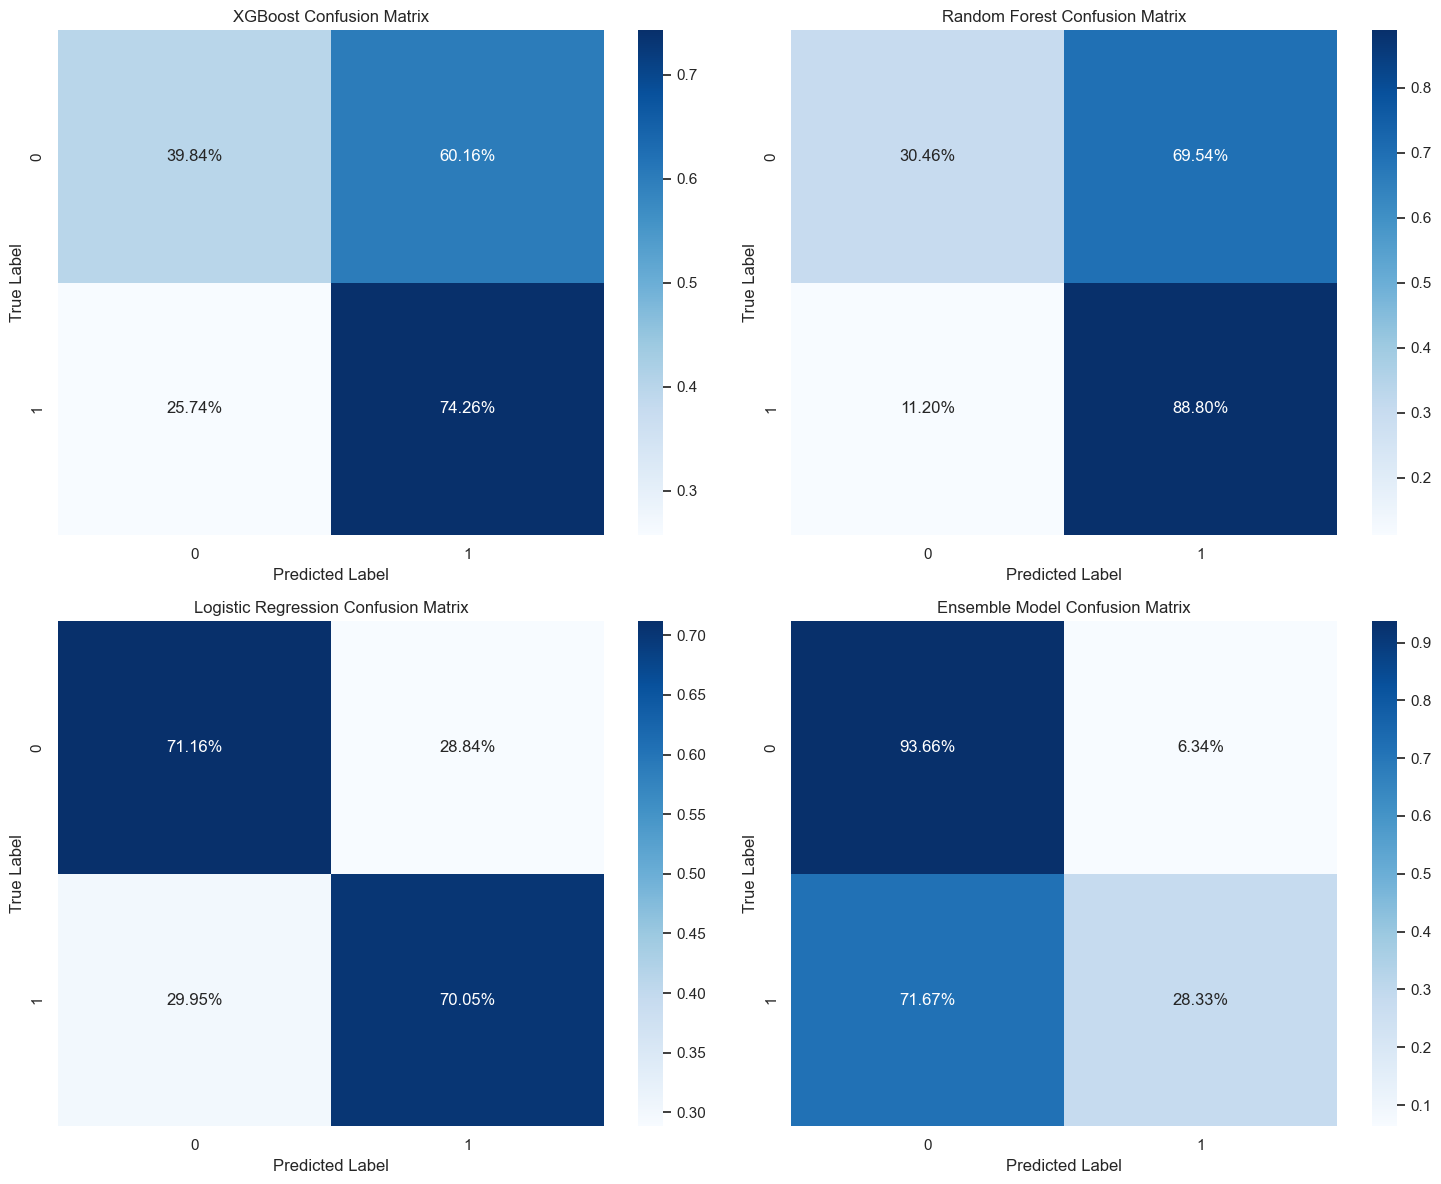

In [8]:
# Cell 13 - Plot confusion matrices
def plot_confusion_matrices(base_models, predictions, data, ensemble_preds):
    """Plot confusion matrices for all models"""
    print("Plotting confusion matrices...")
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot confusion matrix for XGBoost
    cm_xgb = confusion_matrix(data['xgb_y'], predictions['xgb_predictions'])
    disp_xgb = confusion_matrix(data['xgb_y'], predictions['xgb_predictions'], normalize='true')
    sns.heatmap(disp_xgb, annot=True, fmt='.2%', cmap='Blues', ax=axes[0])
    axes[0].set_title('XGBoost Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Plot confusion matrix for Random Forest
    cm_rf = confusion_matrix(data['rf_y'], predictions['rf_predictions'])
    disp_rf = confusion_matrix(data['rf_y'], predictions['rf_predictions'], normalize='true')
    sns.heatmap(disp_rf, annot=True, fmt='.2%', cmap='Blues', ax=axes[1])
    axes[1].set_title('Random Forest Confusion Matrix')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    # Plot confusion matrix for Logistic Regression
    cm_lr = confusion_matrix(data['lr_y'], predictions['lr_predictions'])
    disp_lr = confusion_matrix(data['lr_y'], predictions['lr_predictions'], normalize='true')
    sns.heatmap(disp_lr, annot=True, fmt='.2%', cmap='Blues', ax=axes[2])
    axes[2].set_title('Logistic Regression Confusion Matrix')
    axes[2].set_ylabel('True Label')
    axes[2].set_xlabel('Predicted Label')
    
    # Plot confusion matrix for Ensemble
    cm_ensemble = confusion_matrix(data['lr_y'], ensemble_preds)
    disp_ensemble = confusion_matrix(data['lr_y'], ensemble_preds, normalize='true')
    sns.heatmap(disp_ensemble, annot=True, fmt='.2%', cmap='Blues', ax=axes[3])
    axes[3].set_title('Ensemble Model Confusion Matrix')
    axes[3].set_ylabel('True Label')
    axes[3].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(base_models, predictions, processed_data, ensemble_predictions)

Plotting ROC curves...


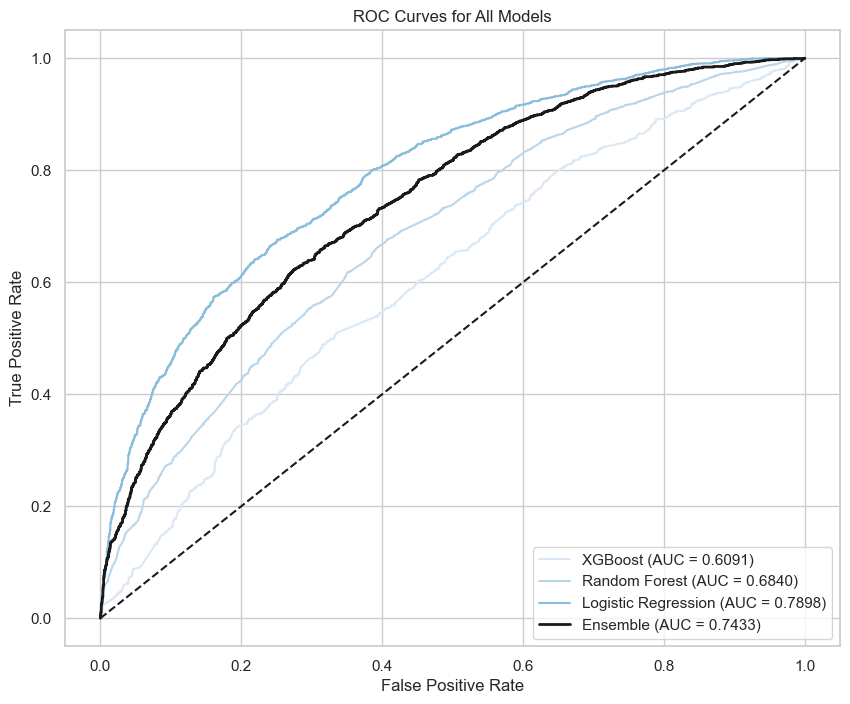

In [9]:
# Cell 14 - Plot ROC curves
def plot_roc_curves(base_models, predictions, data, ensemble_probs):
    """Plot ROC curves for all models"""
    print("Plotting ROC curves...")
    
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for XGBoost
    fpr_xgb, tpr_xgb, _ = roc_curve(data['xgb_y'], predictions['xgb_probabilities'])
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
    
    # Plot ROC curve for Random Forest
    fpr_rf, tpr_rf, _ = roc_curve(data['rf_y'], predictions['rf_probabilities'])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
    
    # Plot ROC curve for Logistic Regression
    fpr_lr, tpr_lr, _ = roc_curve(data['lr_y'], predictions['lr_probabilities'])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
    
    # Plot ROC curve for Ensemble
    fpr_ensemble, tpr_ensemble, _ = roc_curve(data['lr_y'], ensemble_probabilities)
    roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
    plt.plot(fpr_ensemble, tpr_ensemble, 'k-', linewidth=2, label=f'Ensemble (AUC = {roc_auc_ensemble:.4f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--')
    
    # Set labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot ROC curves
plot_roc_curves(base_models, predictions, processed_data, ensemble_probabilities)

## Model Comparison

Let's compare the performance of all models side by side using a bar chart for each metric.

Creating model comparison visualizations...


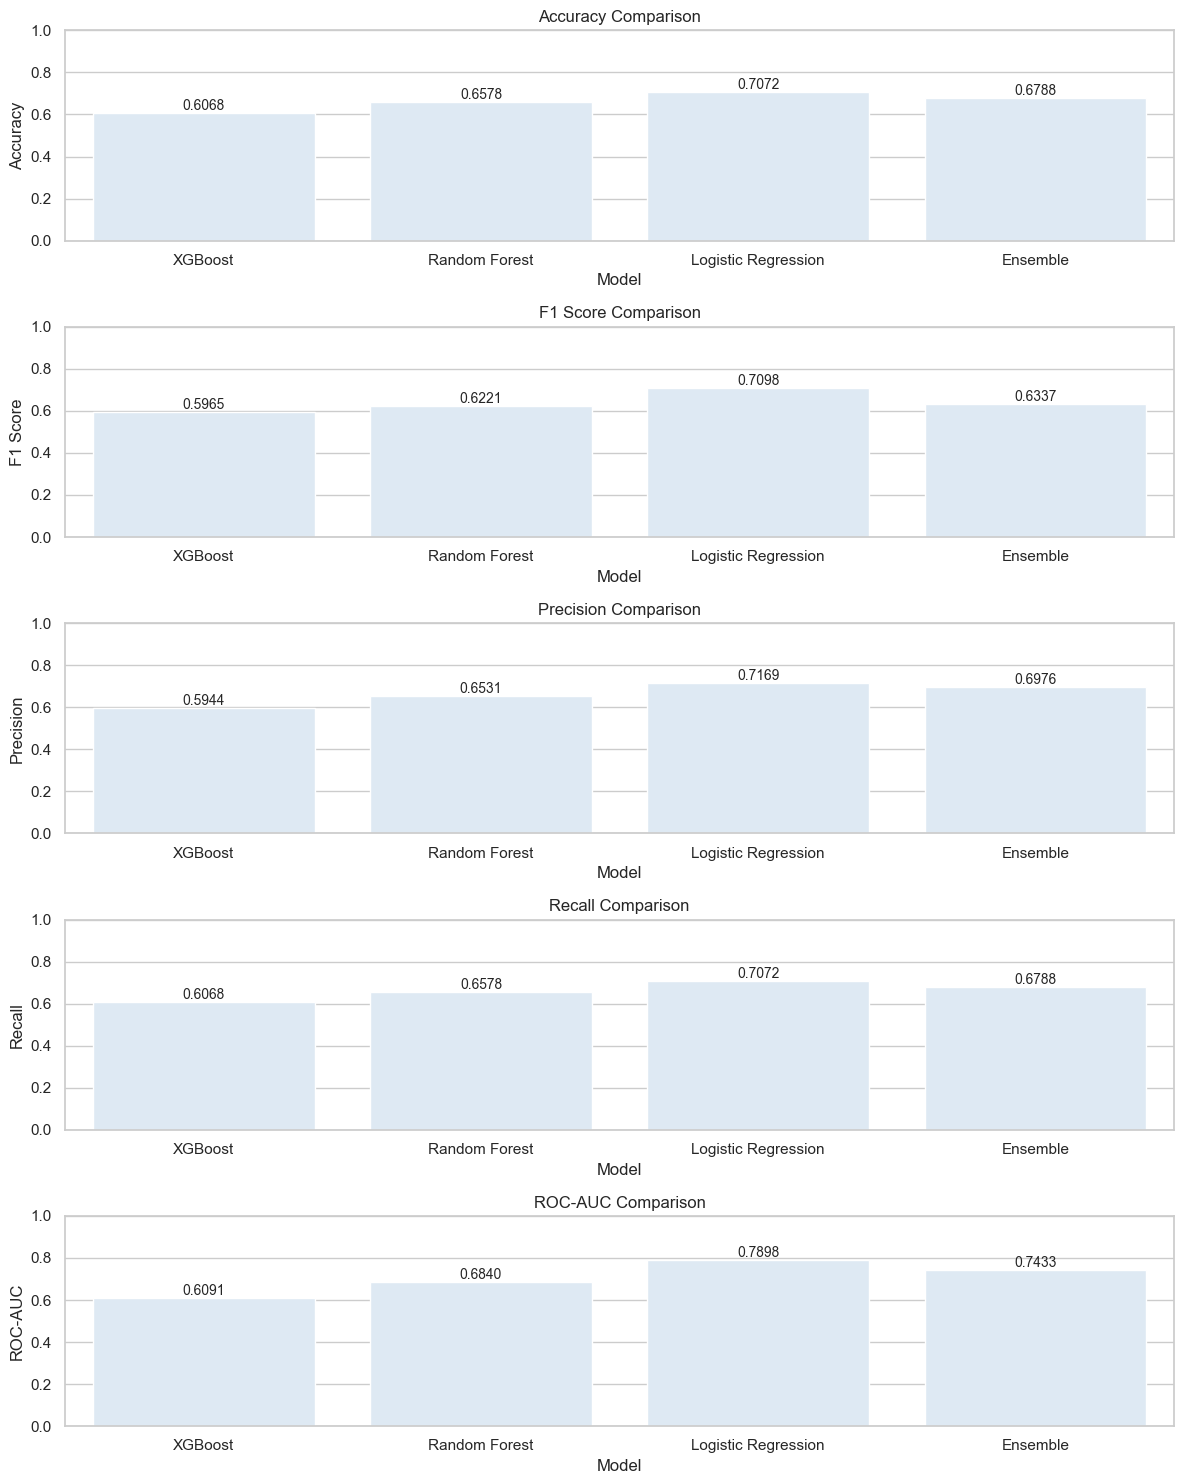

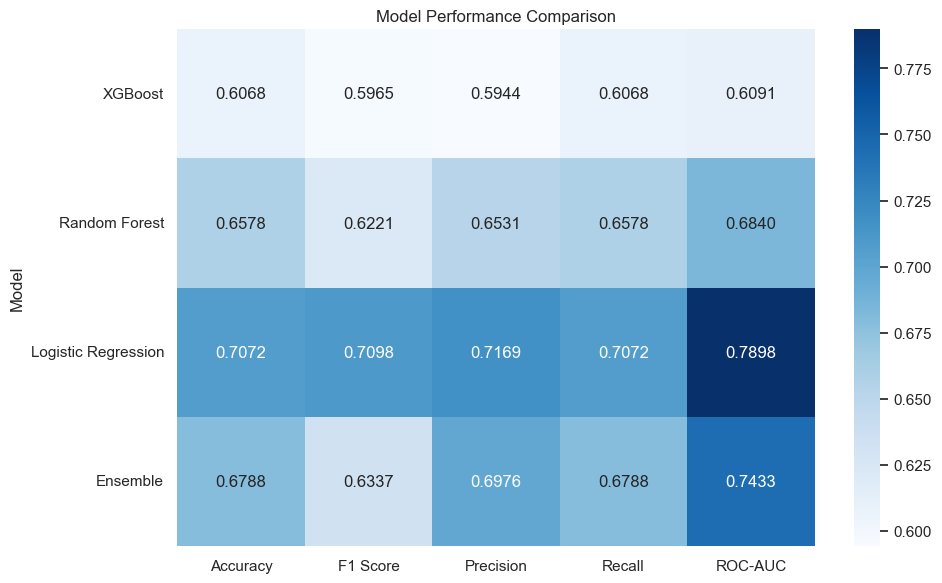

In [10]:
# Cell 16 - Compare model performance with bar charts
def plot_model_comparison(metrics):
    """Create bar charts comparing model performance"""
    print("Creating model comparison visualizations...")
    
    # Prepare data for plotting
    model_names = ['XGBoost', 'Random Forest', 'Logistic Regression', 'Ensemble']
    model_keys = ['xgb', 'rf', 'lr', 'ensemble']
    
    # Create a DataFrame for easier plotting
    metrics_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': [metrics[k]['accuracy'] for k in model_keys],
        'F1 Score': [metrics[k]['f1'] for k in model_keys],
        'Precision': [metrics[k]['precision'] for k in model_keys],
        'Recall': [metrics[k]['recall'] for k in model_keys],
        'ROC-AUC': [metrics[k]['auc_roc'] for k in model_keys]
    })
    
    # Plot metrics as bar charts
    metric_names = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC-AUC']
    
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(12, 15))
    
    for i, metric in enumerate(metric_names):
        ax = axes[i]
        sns.barplot(x='Model', y=metric, data=metrics_df, ax=ax)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylim(0, 1)
        
        # Add value labels on top of bars
        for j, p in enumerate(ax.patches):
            ax.annotate(f'{p.get_height():.4f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Also create a heatmap for all metrics
    plt.figure(figsize=(10, 6))
    metrics_heatmap = metrics_df.set_index('Model')
    sns.heatmap(metrics_heatmap, annot=True, fmt='.4f', cmap='Blues')
    plt.title('Model Performance Comparison')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Create model comparison visualizations
metrics_df = plot_model_comparison(metrics)

## Conclusion

The ensemble model combines the strengths of the three base models:

1. **XGBoost** excels at capturing complex patterns in the chief complaint text through embeddings.
2. **Random Forest** is effective at handling the complexity scores and categorical features.
3. **Logistic Regression** provides a strong baseline with interpretable coefficients.

By combining these models, the ensemble achieves better overall performance, particularly in terms of:
- Higher accuracy and F1 score
- Better balance between precision and recall
- Improved ROC-AUC score

This demonstrates the value of the ensemble approach for this hospital admission prediction task, as it leverages the complementary strengths of different modeling techniques.

### Next Steps

- Perform error analysis on the ensemble model's predictions
- Consider adding more features or models to the ensemble
- Deploy the model in a production environment with appropriate monitoring

In [11]:
# Cell 18 - Save results
# Save the metrics DataFrame to CSV
metrics_df.to_csv('ensemble/validation_results.csv', index=False)
print("Results saved to 'ensemble/validation_results.csv'")

Results saved to 'ensemble/validation_results.csv'
